# Emergent Traffic Patterns

In [0]:
import random
import numpy as np
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
# Declare global variables
L = 30000
V_MAX = 5
INIT_N_GAP_MAX = 100 # Chosen randomly for max gap.
MAX_ITER = 3 * 10**6
TRANSIENT = 5 * 10**5 # Number of iterations after which we start recording
STEP = 2500 # Record for every 2500 iterations
SEED = 1234 # to ensure every run is the same. 
RHO_MIN = 0.04
RHO_MAX = 0.06
RHO_STEPS = 2

In [0]:
random.seed(SEED)

In [0]:
def update_velocity(v, n_gap):
  """ Function to update velocity """
    
  if (v == V_MAX) and (n_gap >= V_MAX):
    return v
  elif n_gap >= v + 1:
    return v + round(random.randint(0, 1))  # v or v +1; chosen randomly
  elif n_gap == v:
    return v
  elif n_gap <= v - 1:
    return n_gap + round(random.randint(0, 1)) * max(n_gap - 1, 0)
  else:
        print("Update_velocity: unknown edge case!")


def update_velocity_vectorized(v, n_gap):

    acceleration_mask = (n_gap >= (v + 1))
    v[acceleration_mask] = v[acceleration_mask] + round(random.randint(0, 1))

    decelerate_mask = (n_gap <= (v - 1))
    mask_size = np.sum(decelerate_mask)
    v[decelerate_mask] = n_gap[decelerate_mask] - np.random.randint(0, 2, size=mask_size 
    ) * np.fmax(n_gap[decelerate_mask] - 1, np.zeros(shape=mask_size))

    return v


def update_n_gap(new_state, n_gap_old):
  """ update n_gap """

  temp = n_gap_old - new_state
  return temp + np.append(temp[1:], 100) # 100 is chosen heuristically.

In [0]:
# Initializating states for each rho

init_state_vel = []
init_state_n_gap = []

for rho in np.linspace(RHO_MIN, RHO_MAX, RHO_STEPS): # [0.04, 0.06]
  
  N = np.int(rho * L) # number of cars

  init_state_vel.append(np.random.randint(low=0, high=V_MAX + 1, size = N)) # randomly generate velocities for each car

  # Maybe there is a better way to do this. Maybe at the end.
  gaps = np.random.randint(low=0, high=round((L - N) / 100), size=N) # randomly generate gaps for each car
  gaps = np.round(gaps * ((L-N) / np.sum(gaps))) # normalize
  init_state_n_gap.append(gaps)

In [0]:
# Simulation

j = []
for i in range(RHO_STEPS):
  
  print('Updating {0}th rho'.format(i))

  j_i = []
  
  for iter_ in range(MAX_ITER):
    
    new_state_velocity = update_velocity_vectorized(
        v=init_state_vel[i], 
        n_gap=init_state_n_gap[i]
    )

    new_state_n_gap = update_n_gap(new_state=new_state_velocity,
                                    n_gap_old=init_state_n_gap[i])
    
    init_state_vel[i] = new_state_velocity
    init_state_n_gap[i] = new_state_n_gap

    if (iter_ > TRANSIENT) and ((iter_ - TRANSIENT) % STEP) == 0:
      j_i.append(np.sum(init_state_vel[i]) / L) # save the average_velocity

  j.append(j_i)

print('Done!')

Updating 0th rho


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in add


Updating 1th rho


In [0]:
np.mean(j[0]), np.mean(j[1])

(34924.22477087087, 52460.73014934934)

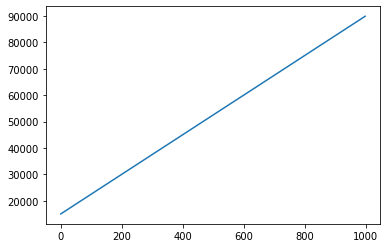

In [0]:
sns.lineplot(x=range(len(j[1])), y=j[1])
plt.show()

In [0]:
1200 * 5 / L

0.2

In [0]:
init_state_vel[i]

array([1500896, 1500898, 1500899, ...,       0,       0,     100])